<a href="https://colab.research.google.com/github/DarShabi/ITC-Final-Project-Scooters/blob/main/MS3_Fine_tunning_the_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import os
import shutil
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


hi

In [3]:
# Correct dimensions
IMG_WIDTH = 150
IMG_HEIGHT = 300


In [4]:
folder_path = '/content/drive/MyDrive/final_proj'

images = glob.glob(folder_path + '/*.jpg')

# Generate labels from the first character of the image file names
labels = [os.path.basename(img)[0] for img in images]


In [5]:
def print_folder_info(folder_path):
    # Get list of all files
    all_files = os.listdir(folder_path)
    # Get classes from filenames
    classes = [file.split('_')[0] for file in all_files]  # Adjust this line if your filenames are structured differently

    # Count classes
    class_counts = {class_: classes.count(class_) for class_ in set(classes)}

    print(f"Total number of files in {folder_path}: {len(all_files)}")
    for class_, count in class_counts.items():
        print(f"Class {class_}: {count} ({(count / len(all_files)) * 100:.2f}%)")

folders = ['train', 'val', 'test']
for folder in folders:
    print_folder_info(os.path.join(folder_path, folder))


Total number of files in /content/drive/MyDrive/final_proj/train: 1686
Class 2: 244 (14.47%)
Class 0: 530 (31.44%)
Class 1: 544 (32.27%)
Class 3: 368 (21.83%)
Total number of files in /content/drive/MyDrive/final_proj/val: 361
Class 3: 70 (19.39%)
Class 2: 48 (13.30%)
Class 0: 108 (29.92%)
Class 1: 135 (37.40%)
Total number of files in /content/drive/MyDrive/final_proj/test: 362
Class 3: 86 (23.76%)
Class 2: 43 (11.88%)
Class 0: 104 (28.73%)
Class 1: 129 (35.64%)


In [6]:
def apply_edge_detection(img, ksize=3, threshold=100):
    # Apply the Sobel filter for vertical and horizontal edge detection on each channel
    sobel_vertical = [cv2.Sobel(img[:,:,i], cv2.CV_64F, 1, 0, ksize=ksize) for i in range(3)]
    sobel_horizontal = [cv2.Sobel(img[:,:,i], cv2.CV_64F, 0, 1, ksize=ksize) for i in range(3)]

    # Calculate magnitude of edges for each channel
    magnitude = [cv2.magnitude(sobel_vertical[i], sobel_horizontal[i]) for i in range(3)]

    # Threshold the magnitude image for each channel
    magnitude_thresh = [cv2.threshold(magnitude[i], threshold, 255, cv2.THRESH_BINARY)[1] for i in range(3)]

    # Convert image to 8-bit for each channel
    magnitude_thresh = [cv2.normalize(magnitude_thresh[i], None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U) for i in range(3)]

    # Stack along the color channel axis
    magnitude_thresh_rgb = np.stack(magnitude_thresh, axis=-1)

    # Cast to float
    return magnitude_thresh_rgb.astype('float32')



In [7]:
def my_augmentation(img):
    # Flip the image horizontally
    img = cv2.flip(img, 1)

    # Apply shear
    factor = 0.7
    rows, cols, _ = img.shape
    M = np.float32([[1, factor, 0], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (cols, rows))

    # Adjust brightness
    # Increase or decrease brightness by 50%
    value = np.random.uniform(0.5, 1.5)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv = np.array(hsv, dtype = np.float32)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return img


In [8]:
def my_preprocessing(img):
    img = my_augmentation(img)
    img = apply_edge_detection(img)
    return img




In [9]:
def extract_class(filename):
    # Get the first character of the filename and convert it to an integer
    class_label = int(filename.split('_')[0])
    return class_label

In [10]:
train_files = os.listdir(folder_path + '/train')
val_files = os.listdir(folder_path + '/val')
test_files = os.listdir(folder_path + '/test')

train_labels = [extract_class(file) for file in train_files]
val_labels = [extract_class(file) for file in val_files]
test_labels = [extract_class(file) for file in test_files]

train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})
test_df = pd.DataFrame({'filename': test_files, 'class': test_labels})


In [11]:
BATCH_SIZE = 16
# Create generator with preprocessing function
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=my_preprocessing)
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=my_preprocessing)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=my_preprocessing)

# Convert class labels to strings
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

# Then call the generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=folder_path + '/train',
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=folder_path + '/val',
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=folder_path + '/test',
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')




Found 1686 validated image filenames belonging to 4 classes.
Found 361 validated image filenames belonging to 4 classes.
Found 362 validated image filenames belonging to 4 classes.


In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)  # Add L2 regularization
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


learning_rate = 0.0001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [13]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=8,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/8
105/105 [==============================] - 33s 212ms/step - loss: 2.0165 - accuracy: 0.3108 - precision: 0.3420 - recall: 0.1497 - val_loss: 1.5872 - val_accuracy: 0.4403 - val_precision: 1.0000 - val_recall: 0.0114
Epoch 2/8
105/105 [==============================] - 16s 149ms/step - loss: 1.6295 - accuracy: 0.3796 - precision: 0.4260 - recall: 0.1707 - val_loss: 1.4062 - val_accuracy: 0.5028 - val_precision: 0.9231 - val_recall: 0.0682
Epoch 3/8
105/105 [==============================] - 16s 148ms/step - loss: 1.4763 - accuracy: 0.4066 - precision: 0.4807 - recall: 0.1934 - val_loss: 1.3295 - val_accuracy: 0.5511 - val_precision: 0.8600 - val_recall: 0.1222
Epoch 4/8
105/105 [==============================] - 24s 231ms/step - loss: 1.3583 - accuracy: 0.4826 - precision: 0.5950 - recall: 0.2569 - val_loss: 1.2702 - val_accuracy: 0.5227 - val_precision: 0.7739 - val_recall: 0.2528
Epoch 5/8
105/105 [==============================] - 18s 174ms/step - loss: 1.2896 - accuracy: 0

In [14]:
model.load_weights('best_model.h5')


In [15]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

23/23 [==============================] - 5s 204ms/step


              precision    recall  f1-score   support

           0       0.31      0.46      0.37       104
           1       0.33      0.33      0.33       129
           2       0.08      0.09      0.09        43
           3       0.28      0.09      0.14        86

    accuracy                           0.28       362
   macro avg       0.25      0.25      0.23       362
weighted avg       0.28      0.28      0.27       362



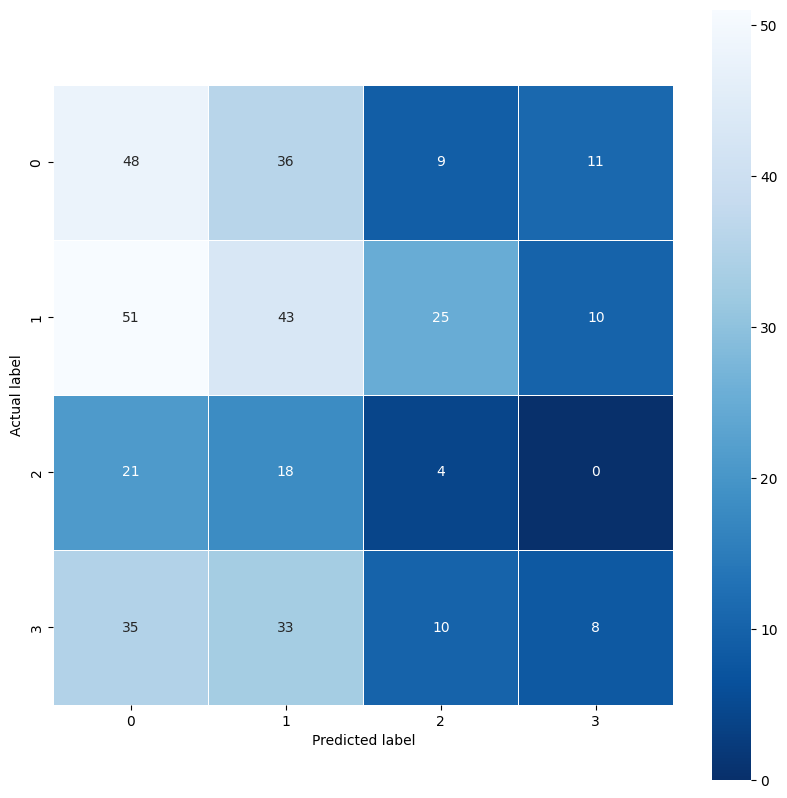

In [16]:
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Print the classification report
cr = classification_report(y_true, y_pred)
print(cr)
